# Ensemble Learning

集成学习的思想很简单，就是构建多个学习器一起结合来完成具体的学习任务。通过将多个学习器进行结合，常可获得比单一学习器显著优越的泛化性能，对弱学习器尤为明显。（三个臭皮匠，顶个诸葛亮）

弱学习器是指学习器的学习正确率仅比随机猜测略好，强学习器是指学习器的学习正确率很高。集成学习就是结合多个弱分类器组成一个强分类器。

集成学习可以分成两类：

- 个体学习器间存在强依赖关系，必须串行生成学习模型。代表：Boosting（AdaBoost, Gradient Boosting Machine）。
- 个体学习器间不存在强依赖关系，可同时生成学习模型。代表：Bagging和随机森林（Random Forest）。

AdaBoost通过改变训练数据的权重分布来训练一组弱分类器，把这些弱分类器线性组合成为一个强分类器。GBDT结合提升树模型和梯度提升的优点，使用新弱分类器拟合前一次迭代模型的样本余量，逐渐降低训练误差。Bagging和随机森林利用自助采样采集T组训练样本集，分别训练T个分类器，对T个分类器的预测结果进行投票决定模型的最终预测结果。
本次作业我们要实现adaboost, GBDT和Random Forest三个模型，为方便模型编写，我们采用scikit-learn构建CART树作为弱学习器。此外，添加了一个实战机器学习任务，Kaggle经典竞赛Titanic生存预测，通过这个任务大家可以比较不同集成学习算法的优劣。

提示：scikit-learn是一个简单而有效的python机器学习算法库，里面包含了许多常见的机器学习算法（包括本课程讲的算法）。这里直接使用scikit-learn实现的CART算法，方便我们完成实验。点击[这里](http://scikit-learn.org/stable/)查看scikit-learn的官方文档，点击[这里](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)查看scikit-learn实现的CART算法的API接口。

In [1]:
# 导入所需的包
import numpy as np
import pandas as pd 
import math
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification

#### **任务1：**构建一个简单的二分类数据集，了解并使用scikit-learn的DecisionTreeClassifier模块快速构建CART树并拟合数据集。

请参考scikit-learn官方文档
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

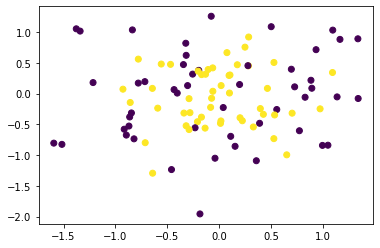

In [2]:
# 使用scikit-learn生成一个简单的二分类数据集
X, y = make_circles(n_samples=100, noise=0.5, factor=0.2, random_state=1)

# 二分类标签一般是‘0’和‘1’，adaboost算法的标签为‘1’，‘-1’，修改adaboost标签‘0’变为‘-1’
y_ada = y.copy()
y_ada[y_ada == 0] = -1

# 可视化生成的数据集
plt.scatter(X[:, 0], X[:, 1], c=y)

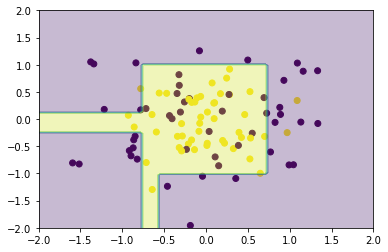

In [3]:
# 首先使用CART对数据进行训练

# 要求采用DecisionTreeClassifier构建最大深度为5，其余为默认参数的决策树模型，并使用fit方法拟合生成的(X, y)数据，采用score方法测试模型精度
cart_model = DecisionTreeClassifier(max_depth = 5)
cart_model.fit(X, y)

# 可视化CART的分类效果
x1_grid = np.linspace(-2, 2, 100)
x2_grid = np.linspace(-2, 2, 100)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
y_grid_simple = np.zeros_like(x1_grid)
X_grid = np.hstack([x1_grid.reshape(-1, 1), x2_grid.reshape(-1, 1)])

# 采用predict方法使用生成模型进行分类预测
y_grid = cart_model.predict(X_grid, check_input=True)
y_grid_simple = y_grid.reshape(100, 100)

#可视化结果
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.contourf(x1_grid, x2_grid, y_grid_simple, alpha=0.3)

## AdaBoost

提升方法是从弱学习算法出发，反复学习，得到一系列弱分类器，然后组合这些弱分类器，构成一个强分类器。对于提升方法来说，有两个问题需要回答：一是在每一轮如何改变训练数据的权值或概率分布；二是如何将弱分类器组合成一个强分类器。关于第1个问题，AdaBoost的做法是，提高那些被前一轮弱分类器错误分类样本的权值，而降低那些被正确分类样本的权值。这样一来，那些没有得到正确分类的数据，由于其权值的加大而受到后一轮的弱分类器的更大关注。于是，分类问题被一系列的弱分类器“分而治之”。至于第2个问题，即弱分类器的组合，AdaBoost采取加权多数表决的方法。具体地，加大分类误差率小的弱分类器的权值，使其在表决中起较大的作用，减少分类误差率大的弱分类器的权值，使其在表决中起较少的作用。

假设给定一个二分类的训练数据集
$$
T = \{(x_1, y_1), (x_2, y_2), \cdots, (x_N, y_N)\}
$$
其中，每个样本点由实例与标记组成。实例$x_i \in \mathcal{X} \subseteq R^n$，$y_i \in \mathcal{Y} = \{-1, +1\}$，$\mathcal{X}$是实例空间，$\mathcal{Y}$是标记集合。AdaBoost利用以下算法，从训练数据中学习一系列弱分类器或基本分类器，并将这些弱分类器线性组合成为一个强分类器。

输入：训练数据集$T=\{(x_1, y_1), (x_2, y_2), \cdots, (x_N, y_N)\}$，其中$x_i \in \mathcal{X} \subseteq R^n$，$y_i \in \mathcal{Y} = \{-1, +1\}$；  
输出：最终分类器$G(x)$。  
(1)初始化训练数据的权值分布
$$
D_1 = (w_{11}, \cdots, w_{1i}, \cdots, w_{1N}), w_{1i} = \frac{1}{N}, i = 1, 2, \cdots, N
$$
(2)对$m=1,2,\cdots,M$  
(a)使用具有权值分布$D_m$的训练数据集学习，得到基本分类器
$$
G_m(x):\mathcal{X}\to \{-1, +1\}
$$
(b)计算$G_m(x)$在训练数据集上的分类误差率
$$
e_m = \sum_{i=1}^{N} P(G_m(x_i) \not = y_i) = \sum_{i=1}^{N} w_{mi} I(G_m(x) \not = y_i)
$$
(c)计算$G_m(x)$的系数
$$
\alpha_m = \frac{1}{2} \log \frac{1-e_m}{e_m} \tag{1}
$$
(d)更新训练数据集的权值分布
$$
D_{m+1} = (w_{m+1,1}, \cdots, w_{m+1,i}, \cdots, w_{m+1,N})
$$
$$
w_{m+1, i} = \frac{w_{mi}}{Z_m} \exp (-\alpha_m y_i G_m(x_i))), i = 1, 2, \cdots, N \tag{2}
$$
这里，$Z_m$是规范化因子
$$
Z_m = \sum_{i=1}^{N} w_{mi} \exp(-\alpha_m y_i G_m(x_i))
$$
它使$D_{m+1}$成为一个概率分布。  
(3)构建基本分类器的线性组合
$$
f(x) = \sum_{m=1}^{M} \alpha_m G_m(x)
$$
得到最终分类器
$$
G(x) = sign(f(x)) = sign \left( \sum_{m=1}^{M} \alpha_m G_m(x) \right)
$$
到此，算法结束。

观察公式（1）$e_m$-$\alpha_m$的曲线图


![e_m-alpha_m](./images/image1.png)


可以看到，当分类误差率低时，$\alpha_m$的值较高，当分类误差率高时，$\alpha_m$的值较低。

来考虑一下，$e_m$是否会取0或1。如果$e_m = 0$，说明弱分类器的效果非常好，正确率100%，可以停止迭代了！如果$e_m = 1$，说明弱分类器的对所有样本都分类错误，学习出一个效果最差的分类器， 但这种情况出现的概率微乎其微！

训练数据的权值分布的更新公式（2）可以写成：
$$
w_{m+1,i} = \begin{cases} \frac{w_{mi}}{Z_m}e^{-\alpha_m}, & G_m(x_i) = y_i \\ \frac{w_{mi}}{Z_m}e^{\alpha_m}, & G_m(x_i) \not = y_i \end{cases}
$$
由此可知，被基本分类器$G_m(x)$误分类样本的权值得以扩大，而被正确分类样本的权值得以缩小。因此，误分类样本在下一轮学习中起更大的作用。不改变所给的训练数据，而不断改变训练数据权值的分布，使得训练数据在基本分类器的学习中起不同的作用，这是AdaBoost的一个特点。

#### **任务2：**根据上述描述构建adaboost算法

弱学习器采用scikit-learn的DecisionTreeClassifier实现，其中决策树的深度可由输入参数控制

## Gradient Boosting Machine (GBM)

GBM和AdaBoost一样采用加法模型：$H(x) = \sum_{t=1}^{T} \alpha_t h_t(x)$，但GBM拓展为可以采用其他任意损失$l$（如前面介绍过的平方损失、交叉熵损失等）。

GBM一般采用决策树（或回归树）作为基学习器，称为Gradient Boosting Decision Tree (GBDT)，针对不同问题使用不同的损失函数，分类问题使用指数损失函数，回归问题使用平方误差损失函数。

GBDT的加法模型为:
$$
f_m(x) = \sum_{m=1}^{M} T(x;\Theta_m)
$$
其中$T(x;\Theta_m)$表示决策树；$\Theta_m$为决策树参数；M为树的个数。

GBDT采用前向分步算法。首先确定初始提升树$f_0(x) = 0$，第m步的模型是
$$
f_m(x) = f_{m-1}(x) + T(x; \Theta_m)
$$
其中，$f_{m-1}$为当前模型，通过经验风险极小化确定下一棵决策树的参数$\Theta_m$，
$$
\hat{\Theta}_m = \arg \underset{\Theta_m}{\min} \sum_{i=1}^{N} L(y_i, f_{m-1}(x_i) + T(x_i; \Theta_m))
$$
为了能够得到最优的下一棵决策树，Freidman提出了梯度提升（gradient boosting）算法。这是利用最速下降法的近似方法，其关键是利用损失函数的负梯度在当前模型的值
$$
-\left[ \frac{\partial L(y, f(x_i))}{\partial f(x_i)} \right]_{ f(x) = f_{m-1}(x) }
$$
作为回归问题提升树算法中的残差的近似值，拟合一个回归树。

GBDT算法  
输入：训练数据集$T=\{(x_1, y_1), (x_2, y_2), \cdots, (x_N, y_N)\}$，$x_i \in \mathcal{X} \subseteq R^n$，$y_i \in \mathcal{Y} \subseteq R$;  
输出： 回归树$\hat{y}(x)$。  
（1）初始化
$$
f_0(x) = \arg \underset{c}{\min}\sum_{i=1}^{N}L(y_i, c)
$$
（2）对$m=1,2,\cdots,M$  
  (a)对$i=1,2,\cdots,N$，计算
$$
r_{mi} = -\left[ \frac{\partial L(y, f(x_i))}{\partial f(x_i)} \right]_{f(x) = f_{m-1}(x)}
$$
  (b)对$r_{mi}$拟合一个回归树，得到第m棵树的叶结点区域$R_{mj}$，$j=1,2,\cdots,J$  
  (c)对$j=1,2,\cdots,J$，计算
$$
c_{mj} = \arg \underset{c}{\min} \sum_{x_i \in R_{mj}} L(y_i, f_{m-1}(x_i) + c)
$$
  (d)更新$f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J} c_{mj}I(x \in R_{mj})$  
（3）得到回归树
$$
\hat{f}(x) = f_M(x) = \sum_{m=1}^{M} \sum_{j=1}^{J}c_{mj}I(x \in R_{mj})
$$

虽然说GBDT使用的是回归树，当然也可以用于分类问题，还记得Logistic Regression吗？逻辑回归解决的是二元分类问题，softmax可以解决多分类问题。如果损失函数$L(y, f(x_i))$为交叉熵损失，GBDT就可以解决分类问题，如果损失函数$L(y, f(x_i))$为平方差损失，GBDT就可以解决回归问题。

$x_i$的平方差损失为
$$
L(y, f(x_i)) = \frac{1}{2} (y_i - f(x_i))^2
$$
对应的$r_{mi}$为
$$
r_{mi} = -\left[ \frac{\partial L(y, f(x_i))}{\partial f(x_i)} \right]_{f(x) = f_{m-1}(x)} = y - f_{m-1}(x)
$$

$x_i$的交叉熵损失为
$$
L(y, g(x_i)) = - y_i \log (g(x_i)) - (1 - y_i) \log (1 - g(x_i)) 
$$
其中$g(x_i) = sigmoid(f(x_i))$，
对应的$r_{mi}$为
$$
r_{mi} = -\left[ \frac{\partial L(y, f(x_i))}{\partial f(x_i)} \right]_{f(x) = f_{m-1}(x)} = y - g(f_{m-1}(x))
$$

In [4]:
def adaboost(X, y, M, max_depth=None):
    """
    adaboost函数，使用CART作为弱分类器
    参数:
        X: 训练样本
        y: 样本标签, y = {-1, +1}
        M: 使用M个弱分类器
        max_depth: 基学习器CART决策树的最大深度
    返回:
        F: 生成的模型
    """
    num_X, num_feature = X.shape
    
    ### START CODE HERE ###
    # 初始化训练数据的权值分布
    D = np.ones(num_X)
    D/=num_X
    G = []
    alpha = []
    i=0
    for m in range(M):
        # 使用具有权值分布D_m的训练数据集学习，得到基本分类器
        # 使用DecisionTreeClassifier，设置树深度为max_depth
        G_m = DecisionTreeClassifier(max_depth = max_depth)
        # 开始训练(需要给参数sample_weight赋值)
        G_m.fit(X,y,sample_weight=D)
        # 计算G_m在训练数据集上的分类误差率
        y_pred = G_m.predict(X)
        e_m = 1-sum((y_pred==y)*D)
        if e_m == 0:
            break
        if e_m == 1:
            raise ValueError("e_m = {}".format(e_m))
        # 计算G_m的系数
        alpha_m = 0.5*np.log((1-e_m)/e_m)
        # 更新训练数据集的权值分布
        D = D*np.exp(-alpha_m*y*y_pred)
        D = D/np.sum(D)
        # 保存G_m和其系数
        G.append(G_m)
        alpha.append(alpha_m)
    
    # 构建基本分类器的线性组合
    def F(X):
        num_G = len(G)
        score = 0
        for i in range(num_G):
            score += alpha[i]*(G[i].predict(X))
        return np.sign(score)
    ### END CODE HERE ###
    
    return F

#### **任务3：**根据上述描述构建GBDT算法

**注意：**GBDT的弱学习器应采用回归模型，弱学习器采用scikit-learn的DecisionTreeRegressor实现，具体使用和之前的分类模型类似，可以参考[这里](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)，
其中决策树的深度可由输入参数控制

In [5]:
f_m = DecisionTreeRegressor(max_depth = 5,random_state=0)
f_m

DecisionTreeRegressor(max_depth=5, random_state=0)

In [6]:
def sigmoid(x):
    """
    计算sigmoid函数值
    """
    return 1 / (1 + np.exp(-x))

def gbdt_classifier(X, y, M, max_depth=None):
    """
    用于分类的GBDT函数
    参数:
        X: 训练样本
        y: 样本标签，y = {0, +1}
        M: 使用M个回归树
        max_depth: 基学习器CART决策树的最大深度
    返回:
        F: 生成的模型
    """
    ### START CODE HERE ###
    # 用0初始化y_reg
    y_reg = np.zeros(len(y))
    f = []
    
    for m in range(M):
        # 计算r
        r = y-y_reg
        # 拟合r
        # 使用DecisionTreeRegressor，设置树深度为5，random_state=0
        f_m = DecisionTreeRegressor(max_depth = 5,random_state=0)
        # 开始训练
        f_m.fit(X,r)
        # 更新f
        f.append(f_m)
        y_reg += f_m.predict(X)
    
    def F(X):
        num_X, _ = X.shape
        reg = np.zeros((num_X))
        for t in f:
            reg+=t.predict(X)
        y_pred_gbdt = reg
        # 以0.5为阈值，得到最终分类结果0或1
        one_position = y_pred_gbdt>=0.5
        y_pred_gbdt[one_position] = 1
        y_pred_gbdt[~one_position] = 0
        return y_pred_gbdt
    
    ### END CODE HERE ###
    return F

接下来，采用任务1实现CART的树策略作为弱学习器，即控制弱学习器CART树最大深度为5，分别构建adaboost和GBDT集成学习模型，弱学习器数目设置为10，查看最终结果。运行以下代码，可以看到adaboost和GBDT模型相较于一个CART决策树，准确率都得到了较大的提升。

Accuracy of Adaboost model is 1.0
Accuracy of GBDT model is 1.0


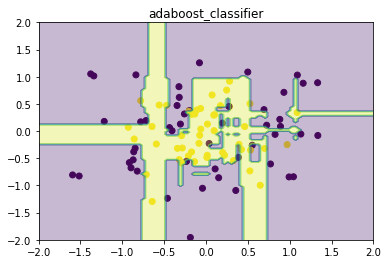

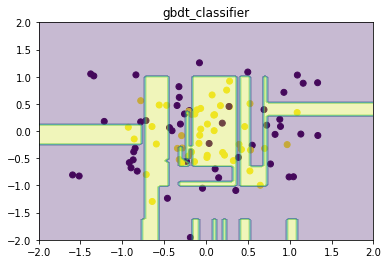

In [7]:
# 用adaboost和GBDT模型进行训练

adaboost_model = adaboost(X, y_ada, 10, max_depth=5)
gbdt_model = gbdt_classifier(X, y, 10, max_depth=5)

y_pre_ada = adaboost_model(X)
y_pre_gbdt = gbdt_model(X)

accuracy_ada = np.mean(y_pre_ada == y_ada)
accuracy_gbdt = np.mean(y_pre_gbdt == y)

print("Accuracy of Adaboost model is {}".format(accuracy_ada))
print("Accuracy of GBDT model is {}".format(accuracy_gbdt))

# 可视化CART的分类效果
x1_grid = np.linspace(-2, 2, 100)
x2_grid = np.linspace(-2, 2, 100)

x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
X_grid = np.hstack([x1_grid.reshape(-1, 1), x2_grid.reshape(-1, 1)])

y_grid_ada = adaboost_model(X_grid)
y_grid_gbdt = gbdt_model(X_grid)

y_grid_simple_ada = y_grid_ada.reshape(100, 100)
y_grid_simple_gbdt = y_grid_gbdt.reshape(100, 100)

ada_fig=plt.figure()
ax1=ada_fig.add_subplot(111)
ax1.set_title('adaboost_classifier')
ax1.scatter(X[:, 0], X[:, 1], c=y_ada)
ax1.contourf(x1_grid, x2_grid, y_grid_simple_ada, alpha=0.3)

gbdt_fig=plt.figure()
ax2=gbdt_fig.add_subplot(111)
ax2.set_title('gbdt_classifier')
ax2.scatter(X[:, 0], X[:, 1], c=y)
ax2.contourf(x1_grid, x2_grid, y_grid_simple_gbdt, alpha=0.3)

plt.show()

## Bagging

Bagging算法很简单，利用自助采样（有放回的均匀抽样）得到T组训练样本集，分别利用这些训练样本集训练T个分类器（CART or SVM or others），最后进行投票集成。

从偏差-方差分解的角度看，Bagging主要关注降低方差，因此它在不剪枝决策树、神经网络等易受样本扰动的学习器上效果更为明显。

## Random Forest

随机森林是Bagging的一个扩展变体，它充分利用“随机”的思想来增加各分类器的多样性。“随机”体现在两个方面：基于自助采样法来选择训练样本和随机选择特征（或属性）。随机选择特征是指，对基决策树的每个节点，先从该节点的属性集合中随机选择一个包含k个属性的子集，然后再从这个子集中选择一个最优属性用于划分。这里的参数k控制了随机性和引入程度，一般情况下，推荐值$k=\log_2d$(假设有d个属性)。随机森林的弱分类器一般是CART。随机森林的特点是可高度并行化、继承了CART的优点和克服了完全生长树的缺点。

Scikit-learn实现的CART算法默认随机选择特征，因此，直接采用bagging算法集成CART树就是Random Forest的实现函数。


#### **任务4：**构建bagging算法

采用投票法作为最终集成的方法

In [8]:
def bagging(X, y, T, size, seed=0, max_depth=None):
    """
    Bagging算法，分类器为CART，用于二分类
    参数：
        X: 训练集
        y: 样本标签
        T: T组
        size: 每组训练集的大小
        seed: 随机种子
        max_depth: 基学习器CART决策树的最大深度
    返回：
        F: 生成的模型
    """
    classifiers = []
    m, n = X.shape
    
    ### START CODE HERE ###
    np.random.seed(seed)
    for i in range(T):
        # 使用np.random.choice选择size个序号，注意replace参数的设置，以满足有放回的均匀抽样。
        index = np.random.choice(m,size)
        X_group = X[index]
        y_group = y[index]
        # 使用tree.DecisionTreeClassifier，设置max_depth=max_depth, min_samples_split=2(生成完全树),random_state=0
        t = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=2,random_state=0)
        # 开始训练
        t.fit(X_group,y_group)
        classifiers.append(t)
        
    def F(X):
        # 计算所有分类器的预测结果
        result = []
        for t in classifiers:
            result.append(t.predict(X))
        # 把预测结果组成 num_X * T 的矩阵
        pred = np.array(result).T
        # 计算"0"有多少投票
        vote_0 = np.sum(pred==0,axis=1)
        # 计算"1"有多少投票
        vote_1 = np.sum(pred==1,axis=1)
        # 选择投票数最多的一个标签
        pred = vote_1>vote_0
        return pred     
    ### END CODE HERE ###
    
    return F

至此，三大集成学习算法都已经实现了。集成学习这一章节结束，我们已经学习了大部分的经典的监督学习算法。下面我们考虑完成一个基础的机器学习应用。

## Titanic: Machine Learning from Disaster

Titanic生存预测是kaggle竞赛机器学习入门的经典题目，Kaggle提供的数据集中，共有1309名乘客数据，其中891是已知存活情况，剩下418则是需要进行分析预测的。我们采用其提供的训练数据titanic_train.csv来进行本次实验。

首先来看一下titanic_train.csv共有891条数据，包含一下内容：

PassengerId: 乘客编号  
Survived   : 存活情况（存活：1 ; 死亡：0）  
Pclass     : 客舱等级  
Name       : 乘客姓名  
Sex        : 性别  
Age        : 年龄  
SibSp      : 同乘的兄弟姐妹/配偶数  
Parch      : 同乘的父母/小孩数  
Ticket     : 船票编号  
Fare       : 船票价格  
Cabin      : 客舱号  
Embarked   : 登船港口  

PassengerId :   891 non-null int64  
Survived    :   891 non-null int64  
Pclass      :   891 non-null int64  
Name        :   891 non-null object  
Sex         :   891 non-null object  
Age         :   714 non-null float64  
SibSp       :   891 non-null int64  
Parch       :   891 non-null int64  
Ticket      :   891 non-null object  
Fare        :   891 non-null float64  
Cabin       :   204 non-null object  
Embarked    :   889 non-null object  

在实际的机器学习任务中，数据处理应占整个项目相当大的比例，怎样从原始数据中心得到有效的信息，对于建模及其关键。Titanic数据集中有部分信息是缺失的，如何选取有效字段进行保留，如何补全缺失值，使我们在进行建模前需要考虑的问题。
这里提供一个Titanic数据集比较全面的数据分析过程，大家可以从中学习和了解机器学习数据清洗的方法。[链接](https://www.kaggle.com/startupsci/titanic-data-science-solutions)

#### **任务5：**处理Titanic训练数据

采用pandas工具进行数据分析[这里](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)可以查看其官方文档。

本次作业我们采用较为简单的方式处理该数据集，去掉姓名，乘客编号和缺失值较多的客舱号三项；采用均值来填满缺失的年龄信息；将性别和登船港口三列转为离散值进行处理；合并SibSp和Parch得到总的家人数。

In [9]:
data_train = pd.read_csv("./titanic/train.csv")
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [10]:
data_train = pd.read_csv("./titanic/train.csv")

### START CODE HERE ###
# 采用mean()得到年龄均值，填补缺失信息
average_age = sum(data_train.Age[data_train.Age.notnull()])/len(data_train.Age.notnull())
data_train.loc[(data_train.Age.isnull()), 'Age' ] = average_age

# 采用pd.get_dummies得到离散数据(使用pd.get_dummies())
dummies_Embarked = pd.get_dummies(data_train.Embarked)
dummies_Sex = pd.get_dummies(data_train.Sex)
dummies_Pclass = pd.get_dummies(data_train.Pclass)

### END CODE HERE ###
# 采用pd.oncat合并原始数据和生成的离散数据
df = pd.concat([data_train, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df['family_num'] = df['SibSp'].values + df['Parch'].values

# 得到最终的训练数据的字段
train_df = df.filter(regex='Survived|Age.*|family_num|Fare.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass.*')
# 显示最终处理完成的数据信息
print(train_df.info())

train_np = np.array(train_df)
print(train_np.shape)


# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

print(X.shape)
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   Fare        891 non-null    float64
 4   family_num  891 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 34.9 KB
None
(891, 5)
(891, 4)
(891,)


In [11]:
train_df

,Survived,Pclass,Age,Fare,family_num
0,0,3,22.000000,7.2500,1
1,1,1,38.000000,71.2833,1
2,1,3,26.000000,7.9250,0
3,1,1,35.000000,53.1000,1
4,0,3,35.000000,8.0500,0
...,...,...,...,...,...
886,0,2,27.000000,13.0000,0
887,1,1,19.000000,30.0000,0
888,0,3,23.799293,23.4500,3
889,1,1,26.000000,30.0000,0


#### 验证试验

采用不同的模型进行训练，包括CART树、adaboost、GBDT和Random Forest算法，其中树的最大深度都固定为10。  


In [12]:
n_splits = 5
kf = KFold(n_splits)
accuracy_train_ada, accuracy_val_ada = 0, 0
accuracy_train_gbdt, accuracy_val_gbdt = 0, 0
accuracy_train_rf, accuracy_val_rf = 0, 0
accuracy_train_CART, accuracy_val_CART = 0, 0

for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    y_train_ada = y_train.copy()
    y_train_ada[y_train_ada == 0] = -1
    y_test_ada = y_test.copy()
    y_test_ada[y_test_ada == 0] = -1
    
    adaboost_model = adaboost(X_train, y_train_ada, 150, max_depth=10)
    gbdt_model = gbdt_classifier(X_train, y_train, 150, max_depth=10)
    randomforest_model = bagging(X_train, y_train, 150, int(X_train.shape[0]*0.4), max_depth=10)
    CART = DecisionTreeClassifier(max_depth=10)
    CART.fit(X_train, y_train)
    
    y_train_pre_ada = adaboost_model(X_train)
    y_test_pre_ada = adaboost_model(X_test)
    y_train_pre_gbdt = gbdt_model(X_train)
    y_test_pre_gbdt = gbdt_model(X_test)
    y_train_pre_rf = randomforest_model(X_train)
    y_test_pre_rf = randomforest_model(X_test)
 
    accuracy_train_CART += CART.score(X_train, y_train)
    accuracy_val_CART += CART.score(X_test, y_test)
    accuracy_train_ada += np.mean(y_train_pre_ada == y_train_ada)
    accuracy_val_ada += np.mean(y_test_pre_ada == y_test_ada)
    accuracy_train_gbdt += np.mean(y_train_pre_gbdt == y_train)
    accuracy_val_gbdt += np.mean(y_test_pre_gbdt == y_test)
    accuracy_train_rf += np.mean(y_train_pre_rf == y_train)
    accuracy_val_rf += np.mean(y_test_pre_rf == y_test)
    
    
print("Accuracy of cart model in trainset is {}, in validation set is {}".format(accuracy_train_CART/n_splits, accuracy_val_CART/n_splits))
print("Accuracy of adaboost model in trainset is {}, in validation set is {}".format(accuracy_train_ada/n_splits, accuracy_val_ada/n_splits))
print("Accuracy of gbdt model in trainset is {}, in validation set is {}".format(accuracy_train_gbdt/n_splits, accuracy_val_gbdt/n_splits))
print("Accuracy of random forest model in trainset is {}, in validation set is {}".format(accuracy_train_rf/n_splits, accuracy_val_rf/n_splits))

Accuracy of cart model in trainset is 0.8521337283514822, in validation set is 0.685788713828385
Accuracy of adaboost model in trainset is 0.9590348582504689, in validation set is 0.6689222271043876
Accuracy of gbdt model in trainset is 0.9590348582504689, in validation set is 0.6756261377189129
Accuracy of random forest model in trainset is 0.8451191357927416, in validation set is 0.6970497771640198


观察上述结果，我们可以发现AdaBoost和GBDT模型主要关注降低错误率（即降低偏差），因此他们能基于分类性能相当弱的学习器构建出分类性能很强的分类器；Bagging主要关注降低方差，因此Random Forest得到的结果在验证集上表现较好，不容易过拟合。

到这里我们本次作业就结束了，有兴趣的同学可以用我们生成的模型去拟合kaggle测试集的数据，提交结果得到最终成绩。

当然这个模型还有很大的提升空间，首先是数据方面，采用更高级的方式补充缺失值，保留姓名字段等方式都可以得到更充足的数据信息，其次模型选择，弱学习器的选择，一些超参数的调节，这些都会对最终的模型产生影响，你也可以采用上述策略去提升kaggle竞赛的最终成绩。